<a href="https://colab.research.google.com/github/Swastik200/30DaysOfDSA/blob/main/Adaboost3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/CMAPSS.zip" "/content"
!unzip CMAPSS.zip

Archive:  CMAPSS.zip
  inflating: CMAPSS/readme.txt       
  inflating: CMAPSS/RUL_FD001.txt    
  inflating: CMAPSS/RUL_FD002.txt    
  inflating: CMAPSS/RUL_FD003.txt    
  inflating: CMAPSS/RUL_FD004.txt    
  inflating: CMAPSS/test_FD001.txt   
  inflating: CMAPSS/test_FD002.txt   
  inflating: CMAPSS/test_FD003.txt   
  inflating: CMAPSS/test_FD004.txt   
  inflating: CMAPSS/train_FD001.txt  
  inflating: CMAPSS/train_FD002.txt  
  inflating: CMAPSS/train_FD003.txt  
  inflating: CMAPSS/train_FD004.txt  
  inflating: CMAPSS/x.txt            


In [4]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [5]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [24]:
path='/content/CMAPSS/'
train_df = pd.read_csv(path+'train_FD003.txt', delimiter=' ', header=None)
test_df = pd.read_csv(path+'test_FD003.txt', delimiter=' ', header=None)
columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 24)]
train_df.columns = columns
test_df.columns=columns

In [25]:
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']

In [26]:
max_cycles = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']

In [27]:
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop('max_cycles', axis=1, inplace=True)

In [28]:
test_df = test_df.merge(max_cycles, on='unit_number', how='left')
test_df['RUL'] = test_df['max_cycles'] - test_df['time_in_cycles']
test_df.drop('max_cycles', axis=1, inplace=True)

In [29]:
features = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
target = 'RUL'

In [30]:
adaboost = AdaBoostRegressor(n_estimators=50, random_state=42)
adaboost.fit(test_df[features], test_df[target])

AdaBoostRegressor(random_state=42)

In [31]:
train_pred = adaboost.predict(train_df[features])
test_pred = adaboost.predict(test_df[features])

In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Remove NaN values from train_df[target] and train_pred
train_df_clean = train_df.dropna(subset=[target])
train_pred_clean = train_pred[~np.isnan(train_df[target])]

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_df_clean[target], train_pred_clean))
print(f"Train RMSE: {train_rmse}")


Train RMSE: 135.25232733431497


In [33]:
test_rmse = sqrt(mean_squared_error(test_df[target], test_pred))
print(f"Test RMSE: {test_rmse}")

Test RMSE: 73.87351240347505


In [34]:
from sklearn.metrics import mean_absolute_error, r2_score

# Remove NaN values from train_df[target] and train_pred
train_df_clean = train_df.dropna(subset=[target])
train_pred_clean = train_pred[~np.isnan(train_df[target])]

# Calculate MAE and R2 score
train_mae = mean_absolute_error(train_df_clean[target], train_pred_clean)
train_r2 = r2_score(train_df_clean[target], train_pred_clean)

print(f"Train R2: {train_r2}, MAE: {train_mae}")


Train R2: -0.19399857500036122, MAE: 109.00139590539034


In [35]:
test_mae = mean_absolute_error(test_df[target], test_pred)
test_r2 = r2_score(test_df[target], test_pred)
print(f"Test R2: {test_r2}, MAE: {test_mae}")


Test R2: 0.21322550463412093, MAE: 58.84208940980946


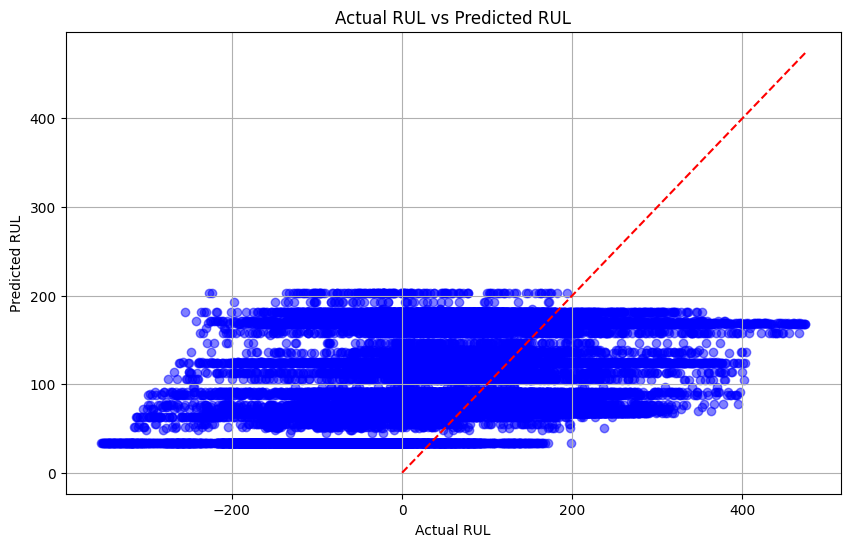

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df[target], train_pred, color='blue', alpha=0.5)
plt.plot([0, train_df[target].max()], [0, train_df[target].max()], color='red', linestyle='--')
plt.title('Actual RUL vs Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()


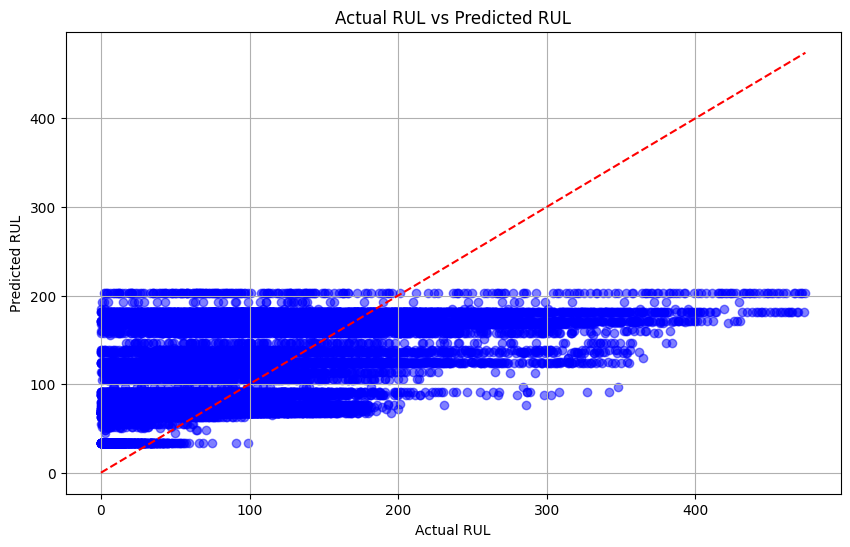

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(test_df[target], test_pred, color='blue', alpha=0.5)
plt.plot([0, test_df[target].max()], [0, test_df[target].max()], color='red', linestyle='--')
plt.title('Actual RUL vs Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()


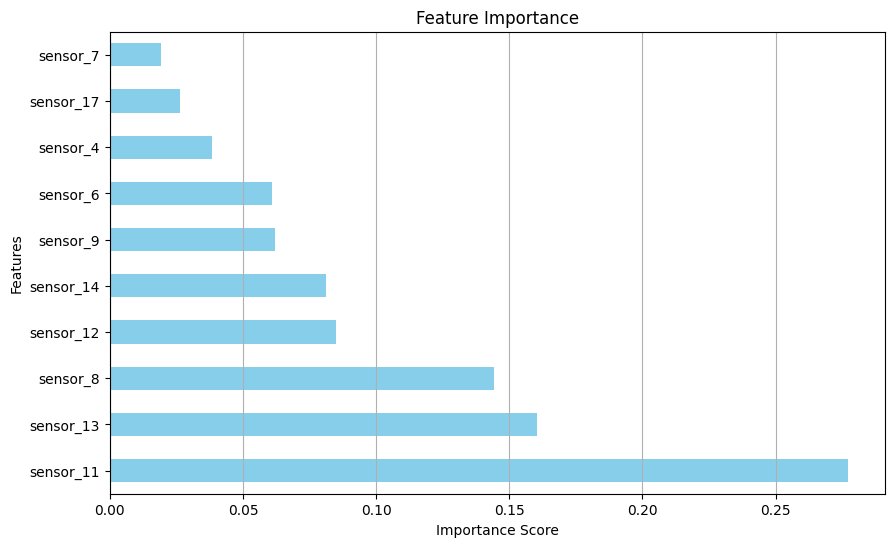

In [38]:
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(adaboost.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()